# AudeyART

This notebook implements a basic version of FuzzyART and tests it out on the relatively "simple" Iris dataset.

FuzzyART is by default an unsupervised learning algorithm (a.k.a. clustering), so this file demonstrates how to cluster the Iris dataset with it.
Future experiments and scripts will show how to do so in a supervised way so that train/test accuracy can be computed.

For now, we will see if a "standard" FuzzyART module can identify some natural structures/clusters in the Iris data without labels.

## Dependencies

First, we load all of our dependencies for the notebook.
Be sure to be working in an activated virtual environment with the requirements installed with

```shell
pip install -r requirements.txt
```

<div class="alert alert-block alert-info">
<b>Note:</b>
More about this in the <a href=README.md> <tt>README.md</tt></a> file.
</div>

In [1]:
# STDLIB IMPORTS

# For manipulating local paths in an object-oriented way
from pathlib import Path

# 3RD PARTY IMPORTS

# The PyTorch library containing neural network utilities and the Tensor datatype
import torch
# A convenient import of Tensor so that we don't have to write torch.Tensor every time
from torch import Tensor
# Pandas for loading and manipulating data as a DataFrame
import pandas as pd
# Numpy for handling numpy arrays (i.e., matplotlib doesn't understand Tensor types, but it does know numpy.nparray)
import numpy as np

# A sklearn utility for handling normalization of data automatically
from sklearn.preprocessing import MinMaxScaler
# From scikit-learn, for casting the data to 2D for visualization.
# This is not how the data actually looks in 4D, but the best that we can do is to cast it to 2D such that relative distances are mostly maintained.
from sklearn.manifold import TSNE
# An sklearn utility for converting a list of text labels into unique integers
from sklearn.preprocessing import LabelEncoder

# The most common way of importing matplotlib for plotting in Python
from matplotlib import pyplot as plt
# For manipulating axis tick locations
from matplotlib import ticker

# An IPython magic syntax that tells matplotlib to plot in a new cell instead of a new window
%matplotlib inline

## Load Data

Next, we will load the dataset with `pandas` as a DataFrane.

In [2]:
# Point to the local data file
datafile = Path("..", "iris", "iris.data")
# Read the data as a CSV, manually declaring the headers since the file doesn't have them
data = pd.read_csv(datafile, names=["SL", "SW", "PL", "PW", "Label"])

# Intialize the scalar and update the values in-place to be normalized between [0, 1]
scaler = MinMaxScaler()
data[["SL", "SW", "PL", "PW"]] = scaler.fit_transform(data[["SL", "SW", "PL", "PW"]])

# Change the text labels to integer labels
label_encoder = LabelEncoder()
data["Label"] = label_encoder.fit_transform(data["Label"])

# Shuffle the data
np.random.seed(12345)
data = data.sample(frac=1).reset_index(drop=True)

# Complement code the data by pushing it into a Tensor
data_cc = torch.Tensor(data[["SL", "SW", "PL", "PW"]].values)
# and appending the vector [1-x] along the feature dimension
data_cc = torch.cat((data_cc, 1 - data_cc), dim=1)
# What we get is a list of 8-dimensional samples
data_cc

tensor([[0.3611, 0.2083, 0.4915,  ..., 0.7917, 0.5085, 0.5833],
        [0.0278, 0.5000, 0.0508,  ..., 0.5000, 0.9492, 0.9583],
        [0.5556, 0.5417, 0.6271,  ..., 0.4583, 0.3729, 0.3750],
        ...,
        [0.5278, 0.3333, 0.6441,  ..., 0.6667, 0.3559, 0.2917],
        [0.8056, 0.4167, 0.8136,  ..., 0.5833, 0.1864, 0.3750],
        [0.1111, 0.5000, 0.1017,  ..., 0.5000, 0.8983, 0.9583]])

Now that we have the data set up, we can infer the number of samples and data dimensions that we are working with.
These two pieces of information will be useful for initializing the module and setting up the training loop.

We have the luxury of knowing all of this information (and being able to know the exact bounds of the data) since the dataset is so small and completely available, but sometimes this info is not entirely clear.
For now, we take advantage of this luxury with the normalization and complement coding above and the data dimension inference below.

In [4]:
# The number of samples is in the first dimensions of the complement-coded data
n_samples = data_cc.shape[0]

# The original dimension of the data is half of the complement coded dimension, which we make sure is cast back to an int
dim = int(data_cc.shape[1] / 2)

## Define AudeyART (FuzzyART) Module

We will implement the FuzzyART module as a Python class containing all of the weights, hyperparamenters, and methods bundled together.
The main interface that we want to the rest of the program is:

1. `AudeyART(...)`: an intialization function where we pass whatever hyperparameters it will need.
These hyperparameters will include what it needs to correctly setup the module structure, and it will also include the running variables such as learning rate, vigilance parameter, etc.
2. `AudeyART.train(x: Tensor)`: to cluster the data, we will take in one sample at a time and train the model incrementally.
Future work will take in an `x` and `y` in the supervised case.
3. `AudeyART.classify(x: Tensor)`: once the model is trained, we need a function that gives predictions of what internal category the provided sample `x` belongs to.
This will mainly be used to visualize the clustering results on the test split.

<div class="alert alert-block alert-info">
<b>Note:</b>
Normally, proper docstrings would be used to document Python class functionality, but I am using inline comments to explain each line step-by-step instead.
</div>

In [5]:
# Define a class that contains everything we need
class AudeyART():

    # The constructor will be where we pass the hyperparameters necessary for the FuzzyART module to work.
    def __init__(
        self,
        dim: int,           # The original dimension of the data
        rho: float=0.6,     # The vigilance parameter in [0, 1]
        beta: float=0.5,    # The learning rate in [0, 1]
        alpha: float=0.001  # The choice parameter (close to zero)
    ):
        # The weights with be of shape [n_categories, 2 * n_dimensions] for complement coded samples
        # NOTE: we start with weights of size [0, 8] with an uninitialized number of categories but known complement-coded dimension length
        self.W = Tensor(size=[0, 2*dim])
        # Keep track of the original dimension for later
        self.dim = dim
        # Save the rest of the operational hyperaparameters
        self.alpha = alpha
        self.beta = beta
        self.rho = rho

        return

    # This function defines how we add a new category to the weight matrix
    def grow(self, x: Tensor):
        # This is a commented print statement for debugging the shapes of everything, kept here for reference
        # print(self.W.shape, x.shape, x.reshape((1, self.dim*2)).shape)

        # Growing the weight matrix ultimately means appending a new weight vector.
        # This is slow how it is written because the memory is overwritten each time we add a new weight, but it works fine for small datasets.
        self.W = torch.cat((self.W, x.reshape((1, self.dim*2))))

        return

    # This function defines what it means to initialize a new category and add it to the weight matrix
    def init_cat(self, x:Tensor):
        # First, we infer the existing number of categories
        n_categories = self.W.shape[0]
        # Next we initialize the "uncommitted node" with all ones
        new_W = torch.ones(2*self.dim)
        # We append the new node to the weights via our grow function
        self.grow(new_W)
        # Then we immediately update that category
        # NOTE: Python is 0-indexed, so the n_categories we got before we appended a new one happens to be the correct index to update
        self.learn(x, n_categories)

        return

    # This is the activation function to compute `T` given sample `x` and the weight at index `j`
    def activation(self, x:Tensor, j:int):
        # We will do this step-by-step to illustrate each computation.
        # First, get the element-wise minimum (fuzzy intersection) of weight `j` and sample `x`.
        xinw = torch.minimum(x, self.W[j, :])
        # Taking the 1-norm is simply a sum
        xinwnorm = torch.sum(xinw)
        # We also need the 1-norm of the weight on its own
        wnorm = torch.sum(self.W[j, :])
        # We compute the activation as the norm of the fuzzy intersection over the weight norm plus the choice parameter (to not divide by zero).
        Tj = xinwnorm / (self.alpha + wnorm)
        # The output is then just this one activation `T` for weight `j`
        return Tj

    # This is the match function to compute `M` given sample `x` and the weight at index `j`
    def match(self, x:Tensor, j:int):
        # Again, the fuzzy intersection is just the elementwise-minimum between sample `x` and weight `j`
        xinw = torch.minimum(x, self.W[j, :])
        # The 1-norm is simply a sum of all elements
        xinwnorm = torch.sum(xinw)
        # The match is defined as fuzzy intersection over the 1-norm of the sample, but we know that the sample is normalized to [0, 1] and complement coded, so that term will always be equal to the original dimension number
        Mj = xinwnorm / self.dim
        # The output here is the match value for weight `j`
        return Mj

    # This function describes what it means to update a winning weight at index `j` with sample `x`
    def learn(self, x:Tensor, j:int):
        # We accidentally wrote the wrong learning function here first, so I am keeping it to show how the learning function (among others) can vary quite a bit between different ART modules
        # self.W[j, :] = self.beta * x + (1-self.beta) * self.W[j, :]

        # The FuzzyART weight update rule is a linear interpolation between the old weight and the fuzzy intersection, and how far along that interpolation we go is set by beta (between [0,1]).
        self.W[j, :] = (1 - self.beta) * self.W[j, :] + self.beta * (torch.minimum(x, self.W[j, :]))

        # Because we wrote this function to update the weight in place, we have an empty return
        return

    # This function is the main training interface, taking one sample at a time
    def train(self, x:Tensor):
        # First, we make sure that we have at least one category
        n_categories = self.W.shape[0]
        # If we don't have any categories, then immediately create one and update it
        if n_categories == 0:
            self.init_cat(x)
            return

        # Next, we compute the activations.
        # NOTE: There are two ways to do this:
        #   1. Preallocate a vector and iterate with a for loop
        #   2. List comprehension, where this is done all at once
        # List comprehension is sometimes slower for complicated low-level reasons, but it is a useful tool in lots of scenarios to make the syntax simpler.

        # OPTION 1: For loop way (commented out for illustration purposes)
        # T = torch.zeros(n_categories)
        # for j in range(n_categories):
        #     T[j] = self.activation(x, j)

        # OPTION 2: List comprehension way
        T = Tensor([self.activation(x, j) for j in range(n_categories)])

        # Next, we do the vigilance check.
        # This will involve going through the weights in order of highest activation and seeing if any of them pass the vigilance criterion.
        # For FuzzyART, this simply means if `Mj > rho`, where `rho` is the vigilance parameter.
        # The first one that passes this check wins and gets updated (hence winner-take-all).
        # If none do, then a new category is created and updated (hence the neurogenesis).

        # There are also two ways to handle the vigilance check programmatically:
        #   1. Sort the activations then iterate
        #   2. argmax the activations iteratively and zero them out if the don't pass.
        # Both methods have pros and cons, but we will go with the sorting procedure since it is simpler (even though it is technically slower since the sort is O(n long(n)) )

        # Sort the activations in order of highest activation first (in torch, this means descending order)
        # NOTE: we want the resulting indices too because we care about the original weight index that was highest activated
        T, inds = torch.sort(T, descending=True)

        # Create a flag that acts as the signal if any weight won
        did_match = False

        # Iterate over the activations in order of highest first
        for _, j in enumerate(T):
            # Extract the index of the current node with a bunch of type casting (ints can be used to index in Python, but torch Tensors can't)
            J = int(inds[int(j)])
            # Compute the match value at that index
            M = self.match(x, J)
            # If the match value is greater than the vigilance parameter, update that weight and stop the search
            if M > self.rho:
                # Update the weight according to the FuzzyART learning rule
                self.learn(x, J)
                # Raise the flag to say that we did have a winner
                did_match = True
                # Stop iterating over the weights
                break

        # If we didnt' have a winner, then create a new weight entirely and immediately update it (similar to how we do if we create the first weight at the top)
        if not did_match:
            self.init_cat(x)

        return

    # This function will classify a provided sample and report the index of the internal category that it belongs to.
    # NOTE: we also have a special option to get the "best-matching-unit" (bmu) in the case of complete mismatch (i.e., the sample was unrecognized), in which case we report the category that had the highest activation.
    def classify(self, x:Tensor, get_bmu: bool = True):
        # First, infer the number of categories that we currently have
        n_categories = self.W.shape[0]

        # Next compute the activations for each category using the list comprehension way
        T = Tensor([self.activation(x, j) for j in range(n_categories)])

        # Start out by saying that the reported value is mismatched, which we code with -1.
        # This will be hopefully overwritten if we have a match
        # NOTE: we initialize it out here because we want y_hat in this scope level so that it is correctly returned
        y_hat = -1

        # Sort the activations like before, keeping track of the corresponding indices
        T, inds = torch.sort(T, descending=True)

        # Have a match flag as before
        did_match = False
        # Iterate in order of highest activation
        for _, j in enumerate(T):
            # Extract the index of the corresponding weight
            J = int(inds[int(j)])
            # Compute the match function for the weight
            M = self.match(x, J)
            # If it satisfies the match criterion, report that category index as our winner
            if M > self.rho:
                # Set the output as that index and break out of the loop
                y_hat = J
                did_match = True
                break

        # If there was not a winner, we would should handle it appropriately
        if not did_match:
            # If we still want to report some actual value, return the highest activated category (which is first in the sorted list)
            if get_bmu:
                y_hat = int(inds[0])
            # Otherwise, return a mismatch signal
            else:
                y_hat = -1

        return y_hat


## Training

We are now ready to train the model!

In the unsupervised case, this means incrementally clustering the full dataset.
For supervised learning scenarios, we would take a train/test split of the data to get an unbiased assessment of the testing accuracy, but in clustering we have no "performance" metric _per se_ (we just have the resulting partitioning).

Therefore, we will first incrementally cluster (train) on the whole dataset, and then we will classify (do inference) on the whole dataset to see how the algorithm partitioned the data.

Also, we will do this in one pass of the data (i.e., one epoch) to show how we can get a pretty good result even after seeing each piece of data only once.

In [6]:
# First initialize the FuzzyART module with our selection of hyperparameters.
# The dimension of the data is necessary, but the others are a matter of selection.
# We will choose fast learning (beta=1.0) and a middle-of-the-road vigilance parameter (rho=0.6).
aart = AudeyART(
    dim,
    rho=0.45,
    beta=1.0,
)

# To train, we loop over every sample
for ix in range(n_samples):
    # Extract the sample as a vector at sample index `ix`
    data_x = data_cc[ix, :]

    # Train the model on the sample!
    # Because this is unsupervised, we have no other information to give to the model besides the sample itself.
    aart.train(data_x)

## Classify

Hooray!
We made and trained a FuzzyART module on the Iris dataset.
But how did it do?

One way we can inspect what it learned is by seeing how many categories were generated during training.

In [7]:
# The lazy way is to just take the shape of the weight matrix and take the first dimension
print(f"Number of categories: {aart.W.shape[0]}")
print(f"Original number of samples: {n_samples}")

Number of categories: 12
Original number of samples: 150


Wowza, it worked!
It is validating that we had fewer categories than we had samples, meaning that the algorithm bucketed the samples together.
Let's get the full list of category labels for each sample to see how it did so:

In [8]:
# Initialize a simple Python vector for the label estimates (i.e., the category indices)
y_hats = []
# Iterate over all of the samples again
for ix in range(n_samples):
    # Extract the single sample as before
    data_x = data_cc[ix, :]
    # Classify the sample, this time getting the label that the FuzzyART algorithm prescribed to it
    y_hat = aart.classify(data_x)
    # Append to our list of labels
    y_hats.append(y_hat)

Now that we have the classifications, lets get an idea of the cluster sizes.
One way to do that is to simply count the number of members in each cluster, which we can do by counting how many samples were assigned to each label:

In [9]:
# The number of unique labels is the length of the list of labels.
n_unique = len(set(y_hats))
# Print the number of samples that got bucketed into that label
for ix in range(n_unique):
    print(f"Number of {ix}'s: {y_hats.count(ix)}")

Number of 0's: 51
Number of 1's: 13
Number of 2's: 70
Number of 3's: 3
Number of 4's: 1
Number of 5's: 4
Number of 6's: 1
Number of 7's: 1
Number of 8's: 1
Number of 9's: 1
Number of 10's: 3
Number of 11's: 1


Interesting!
This type of behavior is common in clustering algorithms.
A small subset of clusters got a lot of samples, and we ended up with a list of singleton clusters (i.e., a cluster with only one or a few samples belonging to them).

## Visualization

We'd like to go one step further and actually see how the samples got clustered on a plot.
Because the Iris dataset is 4-dimensional, we can't directly visualize the data on its own terms.
We could take slices of the data where we look at two dimensions at a time, but that would generate a list of 4C2 (4 choose 2) = 6 plots, which is already a lot for a small set of features.
Imagine if we were working with a dataset with way more features, like the number of pixels in an image!

Instead, we will try to use a common technique called TSNE to project the data into two dimensions, trying to preserve the relative distances between points in the lower dimension as in the higher dimension.
It's not perfect, but it gives us an idea of how the algorithm partitioned the data visually.

In [11]:
# Here, we make a couple of helper functions to set up the plot

# Scatters points TSNE points and colors according to label
def add_2d_scatter(ax, points, colors, title=None):
    x, y = points
    ax.scatter(x, y, s=50, c=colors, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

# Generates the plot itself
def plot_2d(points, y, title):
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in y]
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, colors)
    plt.show()

# Now, we initialize a TSNE module with its own set of hyperparameters for how it will be "trained" to create a mapping between the 4d data and its 2d projection.
t_sne = TSNE(
    n_components=2,
    perplexity=10,
    init="random",
    max_iter=250,
    random_state=0,
)

# The `x` points are the original columns, and the `y` points are FuzzyART's cluster labels of them
x = data[["SL", "SW", "PL", "PW"]].values
y = y_hats

# Fit the TSNE to the data, and return those transformed points
S_t_sne = t_sne.fit_transform(x)

After creating the projection, let's finally visualize the clustering results.
To do that, we will have each scatter point be a different color belonging to the label index.
The specific value (and subsequently color) each value takes is not as important as the fact that they are different, showing that the algorithm bucketed the samples into different clusters.

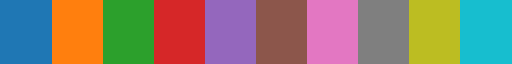

In [12]:
# Visualize the color map for the points
plt.get_cmap('tab10')

Now, lets see what the points look like to see if we successfully clustered anything!

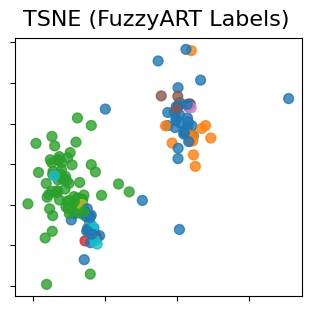

In [13]:
# Generate the plot
plot_2d(S_t_sne.T, y, "TSNE (FuzzyART Labels)")

Neat!
We see that there are some natural clusters in the data that we can visualize with TSNE, and we also see that some of those clusters are a bit entangled (i.e., overlapping in the projected feature space).
For the most part, we got three big clusters with a bunch of outliers, which is largely what we expect from the original data.
After all, we would expect three clusters since the original data had three supervised labels.
How about we plot data with the true labels side-by-side with the clustered labels?

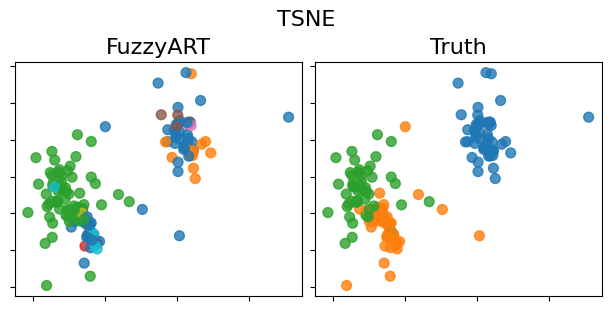

In [14]:
# Generate a side-by-side comparison plot
def plot_side_by_side_2d(x, y1, y2, t1, t2, ttop):
    cmap = plt.get_cmap('tab10')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(ttop, size=16)
    colors = [cmap(i) for i in y1]
    add_2d_scatter(ax1, x, colors)
    ax1.set_title(t1, size=16)

    colors = [cmap(i) for i in y2]
    add_2d_scatter(ax2, x, colors)
    ax2.set_title(t2, size=16)
    plt.show()

plot_side_by_side_2d(S_t_sne.T, y_hats, data["Label"], "FuzzyART", "Truth", "TSNE")

Interesting! We largely captured the original structure of the data, but the clustering results still do not exactly match the original labels (especially with some of the outliers).

Next time, we will make a supervised version of the algorithm and see how it performs!

## Scratch Workspace

These cells just demonstrate some of the tinkering that we did to figure out how to do some crucial low-level stuff using Tensors.
For example, we needed to find out how to append tensors along the right dimension, find the elementwise minimum between two Tensor vectors, and how to cast Tensor values between different types for correctly indexing into other arrays.

In [15]:
# Here, we want to see how to concatenate two Tensors along our desired dimension
a = torch.Tensor(size=[0,2])
b = torch.Tensor(np.array([[1, 1]]))
print(a.shape, b.shape)
c = torch.cat((a, b))
print(c.shape)

torch.Size([0, 2]) torch.Size([1, 2])
torch.Size([1, 2])


In [16]:
# Here, we want to find how to get the index of the argmax of a Tensor (especially with correctly typecasting)
a = torch.randn(3)
b = torch.argmax(a)
print(a, int(b.data))

tensor([ 1.7174, -0.7904, -0.1811]) 0


In [ ]:
# Here, we were tinkering with how to shuffle tensors

# # Get the number of rows
# num_rows = data_cc.shape[0]

# # Generate a random permutation of row indices
# row_indices = torch.randperm(num_rows)

# # Shuffle the rows using advanced indexing
# shuffled_tensor = data_cc[row_indices]